## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'MG'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values
ind_max = np.argmax(disturb)
ind_min = np.argmin(disturb)
print(ind_min, disturb[ind_min], ind_max, disturb[ind_max])

2600 -164.88295930007007 3213 163.24176910007372


In [6]:
# bdg_grav = np.delete(bdg.GRAV.values, [ind_min, ind_max])
# eigen_grav = np.delete(eigen.GRAV.values, [ind_min, ind_max])
# longitude = np.delete(bdg.LONG.values, [ind_min, ind_max])
# latitude = np.delete(bdg.LAT.values, [ind_min, ind_max])
# altitude = np.delete(bdg.ALT_GEOM.values, [ind_min, ind_max])
# disturb = np.delete(disturb, [ind_min, ind_max])
# data = {'LONG':longitude, \
#         'LAT':latitude, \
#         'ALT':altitude, \
#         'BDG':bdg_grav, \
#         'EIGEN':eigen_grav, \
#         'DIST':disturb}
# df = pd.DataFrame(data)
# df

In [7]:
data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

LONG       LAT      ALT        BDG          EIGEN       DIST
0    -46.70770 -17.06180  578.800  978260.90  978261.537238  -0.637238
1    -46.63750 -16.97780  527.430  978267.90  978271.910132  -4.010132
2    -46.70650 -16.98000  529.680  978266.74  978273.472602  -6.732602
3    -46.85880 -17.02990  595.230  978257.48  978259.989801  -2.509801
4    -46.67340 -17.31430  644.290  978261.14  978256.954343   4.185657
...        ...       ...      ...        ...            ...        ...
4791 -45.64882 -15.30444  824.998  978144.54  978148.610632  -4.070632
4792 -44.87921 -16.57089  612.018  978229.35  978233.648291  -4.298291
4793 -42.90652 -21.10414  318.380  978560.96  978575.075768 -14.115768
4794 -44.91501 -21.96209  885.630  978485.74  978501.222586 -15.482586
4795 -42.35544 -21.12435  188.063  978607.21  978606.856273   0.353727

[4796 rows x 6 columns]

In [8]:
# ind_max = np.argmax(disturb)
# ind_min = np.argmin(disturb)
# print(ind_min, disturb[ind_min], ind_max, disturb[ind_max])

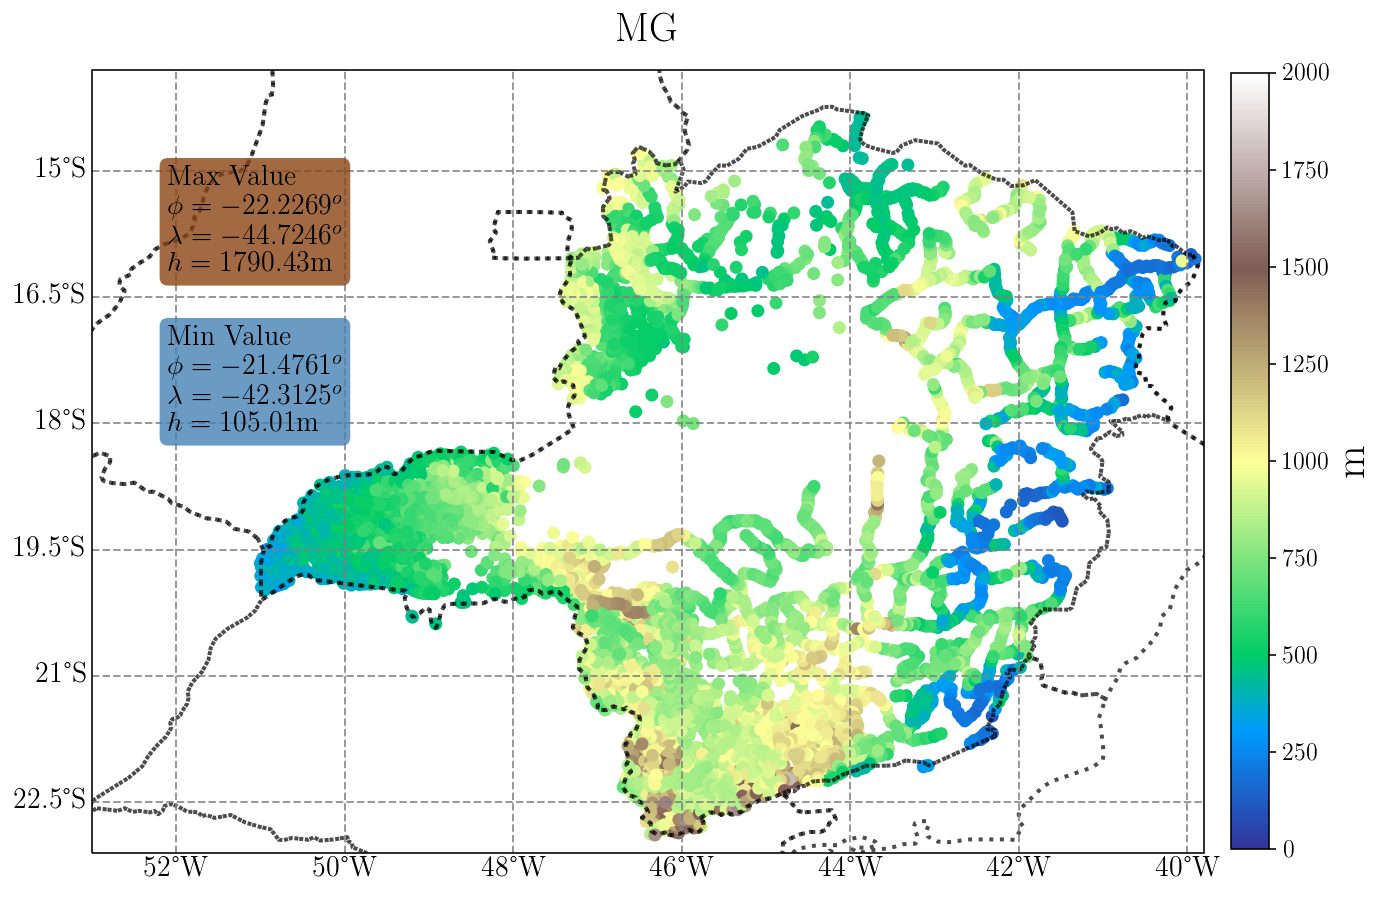

In [9]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(12.,14.), region=[-53.,-39.8,-23.1,-13.8], \
         cmap='terrain', sign=(-52.1,-52.1,-16.2,-18.1), lim_val=(True,True,0.,2000.))

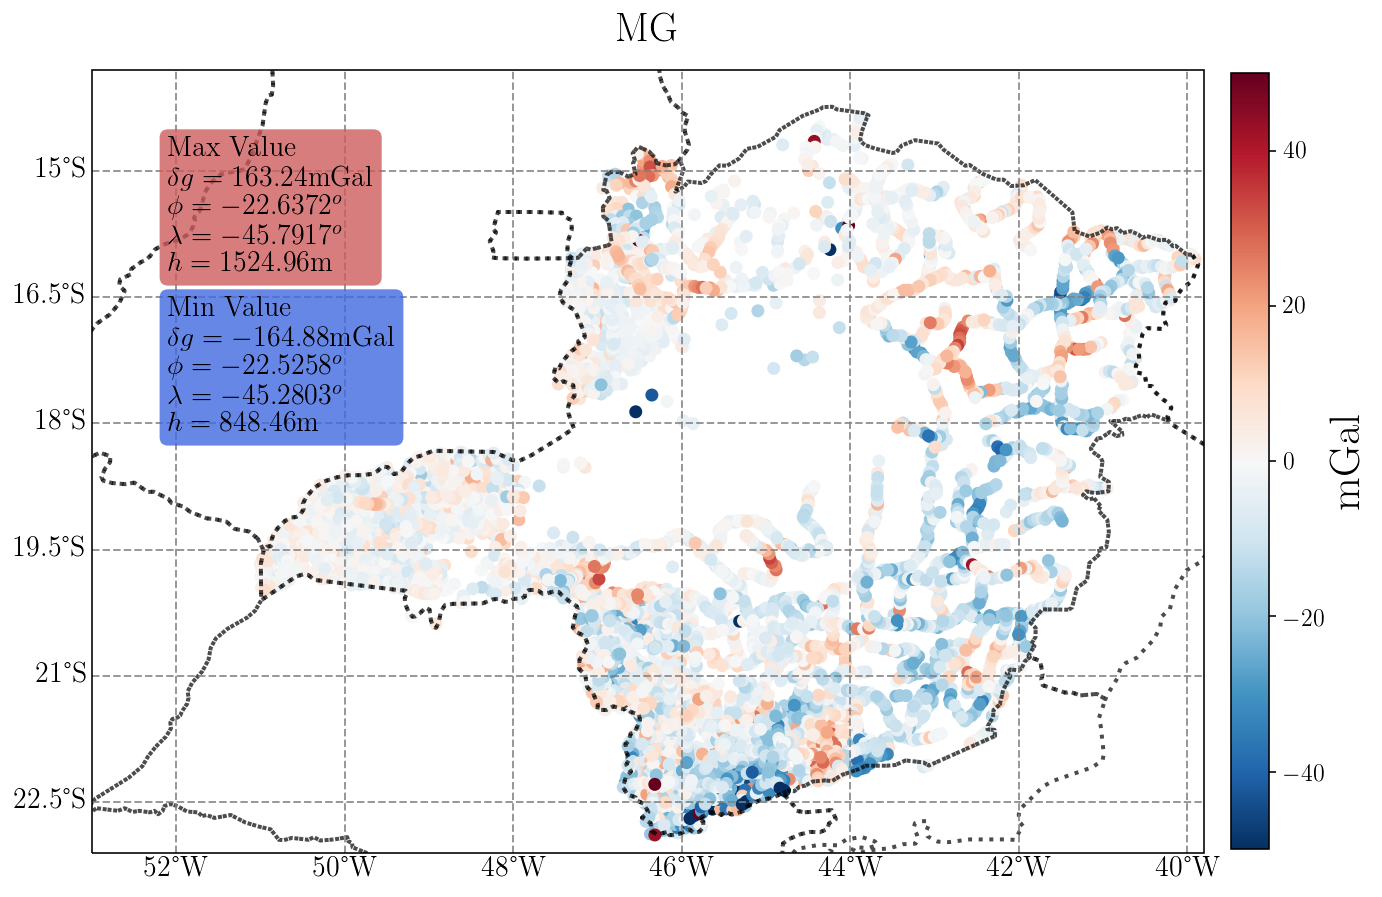

In [10]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-53.,-39.8,-23.1,-13.8], \
         sign=(-52.1,-52.1,-16.2,-18.1), lim_val=(True, 50.))

### Calculating rotation matrices and Cartesian coordinates

In [11]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))

## Estimating the first set of point-mass parameters

In [12]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [13]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [14]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]

In [15]:
Rcl = R[:, indl]

In [16]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(4796, 4796)


In [17]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [18]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

4796


In [19]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [20]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

1.965411589171838

In [21]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [22]:
rabs_max.append(rabs_max_l)

In [23]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

1.965411589171838


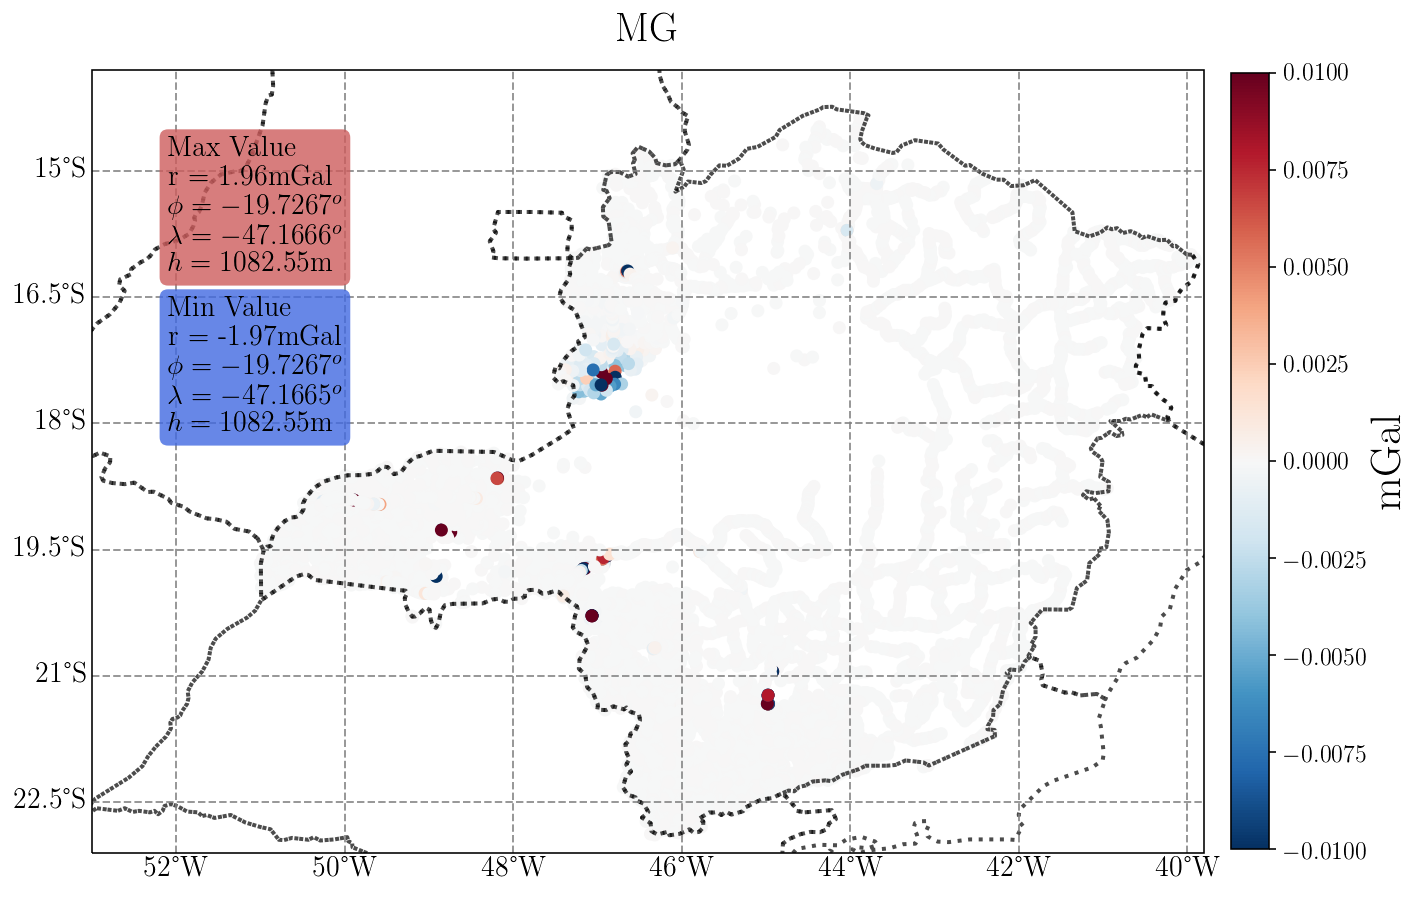

In [24]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(12.,14.), region=[-53.,-39.8,-23.1,-13.8], \
         sign=(-52.1,-52.1,-16.2,-18.1), residual=True, lim_val=(True, 1e-2))

In [25]:
cond = np.where(rc>1e-2, -1, rc)
cond.tolist().count(-1)

20

In [26]:
print(rc.min(), rc.max())
ind_min, ind_max = np.argmin(rc), np.argmax(rc)
print(ind_min, ind_max)
index = np.array([ind_min, ind_max])

-1.965411589171838 1.959681894771002
1958 1153


In [27]:
# index = np.array([ind_min, ind_max])
# rc = np.delete(rc, index)
# longitude = np.delete(df.LONG.values, index)
# latitude = np.delete(df.LAT.values, index)
# altitude = np.delete(df.ALT.values, index)
# point_map(longitude, latitude, altitude, rc, uf, fig_size=(12.,14.), region=[-53.,-39.8,-23.1,-13.8], \
#          sign=(-52.1,-52.1,-16.2,-18.1), residual=True, lim_val=(True, 1e-2))

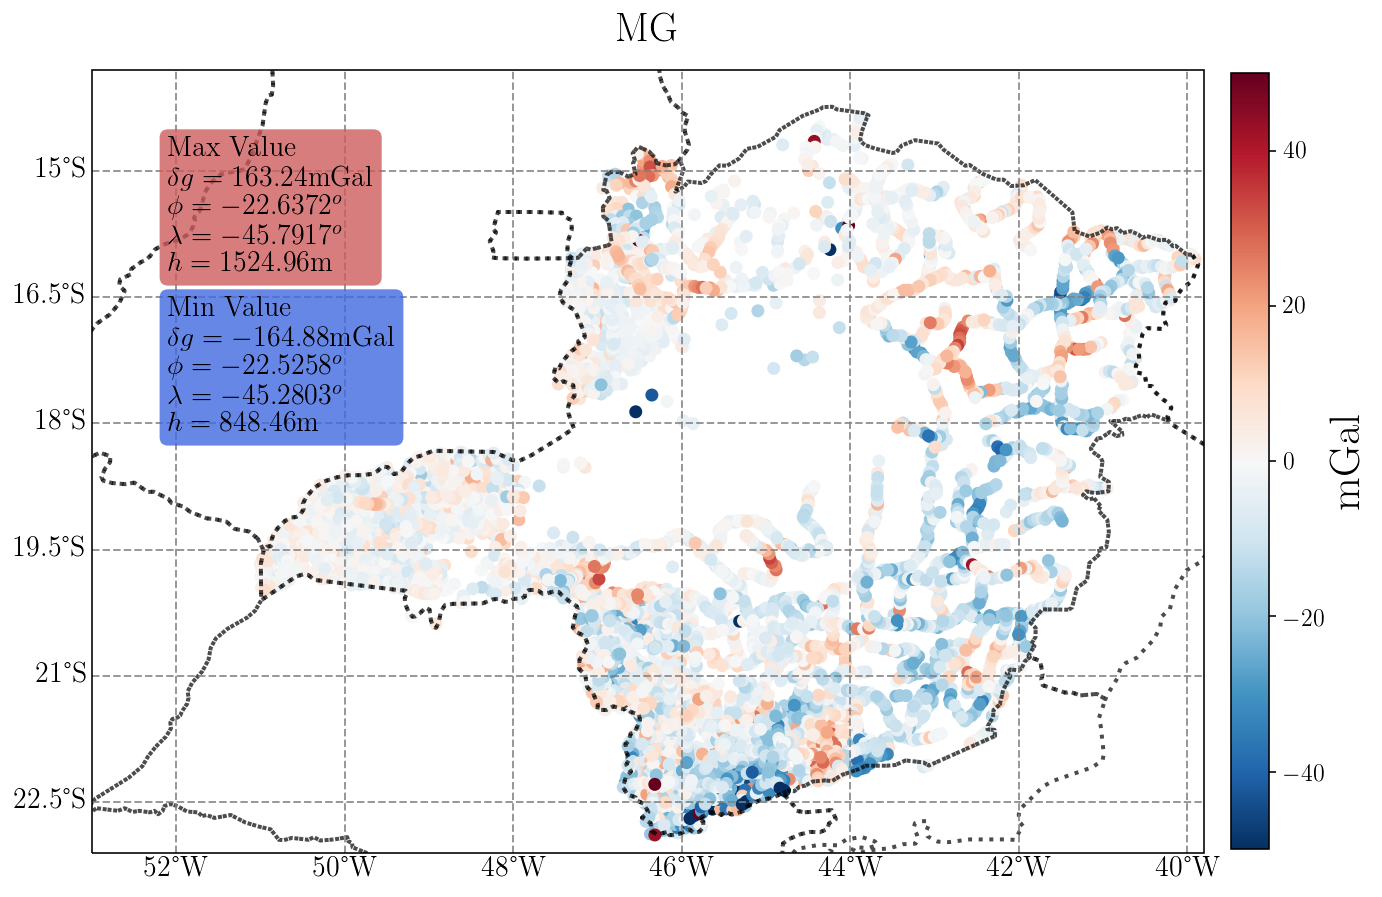

In [28]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-53.,-39.8,-23.1,-13.8], \
         sign=(-52.1,-52.1,-16.2,-18.1), lim_val=(True, 50.))

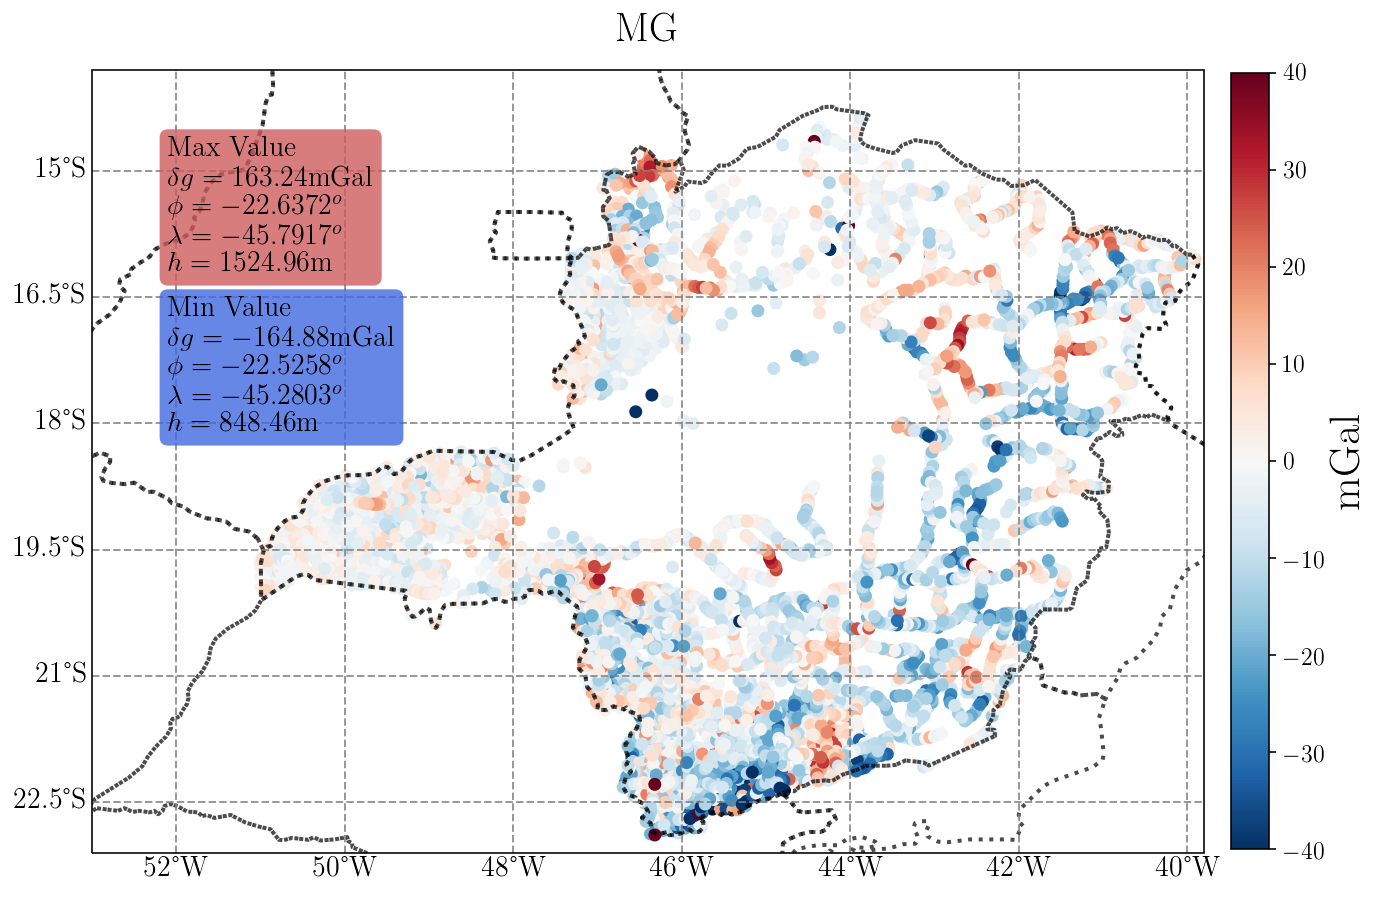

In [29]:
point_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), \
          region=[-53.,-39.8,-23.1,-13.8], sign=(-52.1,-52.1,-16.2,-18.1), lim_val=(True, 40.))

In [30]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [31]:
new_data = {'LONG':bdg.LONG.values, \
            'LAT':bdg.LAT.values, \
            'ALT':bdg.ALT_GEOM.values, \
            'BDG':bdg.GRAV.values, \
            'EIGEN':eigen.GRAV.values, \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

LONG       LAT      ALT        BDG          EIGEN       DIST  \
0    -46.70770 -17.06180  578.800  978260.90  978261.537238  -0.637238   
1    -46.63750 -16.97780  527.430  978267.90  978271.910132  -4.010132   
2    -46.70650 -16.98000  529.680  978266.74  978273.472602  -6.732602   
3    -46.85880 -17.02990  595.230  978257.48  978259.989801  -2.509801   
4    -46.67340 -17.31430  644.290  978261.14  978256.954343   4.185657   
...        ...       ...      ...        ...            ...        ...   
4791 -45.64882 -15.30444  824.998  978144.54  978148.610632  -4.070632   
4792 -44.87921 -16.57089  612.018  978229.35  978233.648291  -4.298291   
4793 -42.90652 -21.10414  318.380  978560.96  978575.075768 -14.115768   
4794 -44.91501 -21.96209  885.630  978485.74  978501.222586 -15.482586   
4795 -42.35544 -21.12435  188.063  978607.21  978606.856273   0.353727   

               RHO     RESID  
0     3.169522e+11  0.000870  
1    -1.329120e+12 -0.000024  
2    -2.646936e+12  0.000168  
3     1.425614e+11 -0.000519  
4     2.212242e+12 -0.003952  
...            ...       ...  
4791 -2.173070e+12  0.000007  
4792 -1.946078e+12 -0.000010  
4793 -4.057833e+12 -0.000005  
4794 -5.412430e+12  0.000005  
4795 -1.164978e+11 -0.000002  

[4796 rows x 8 columns]

In [32]:
print(df.RESID.min(), df.RESID.max())

-1.965411589171838 1.959681894771002


### Upward Continuation

In [33]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [34]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


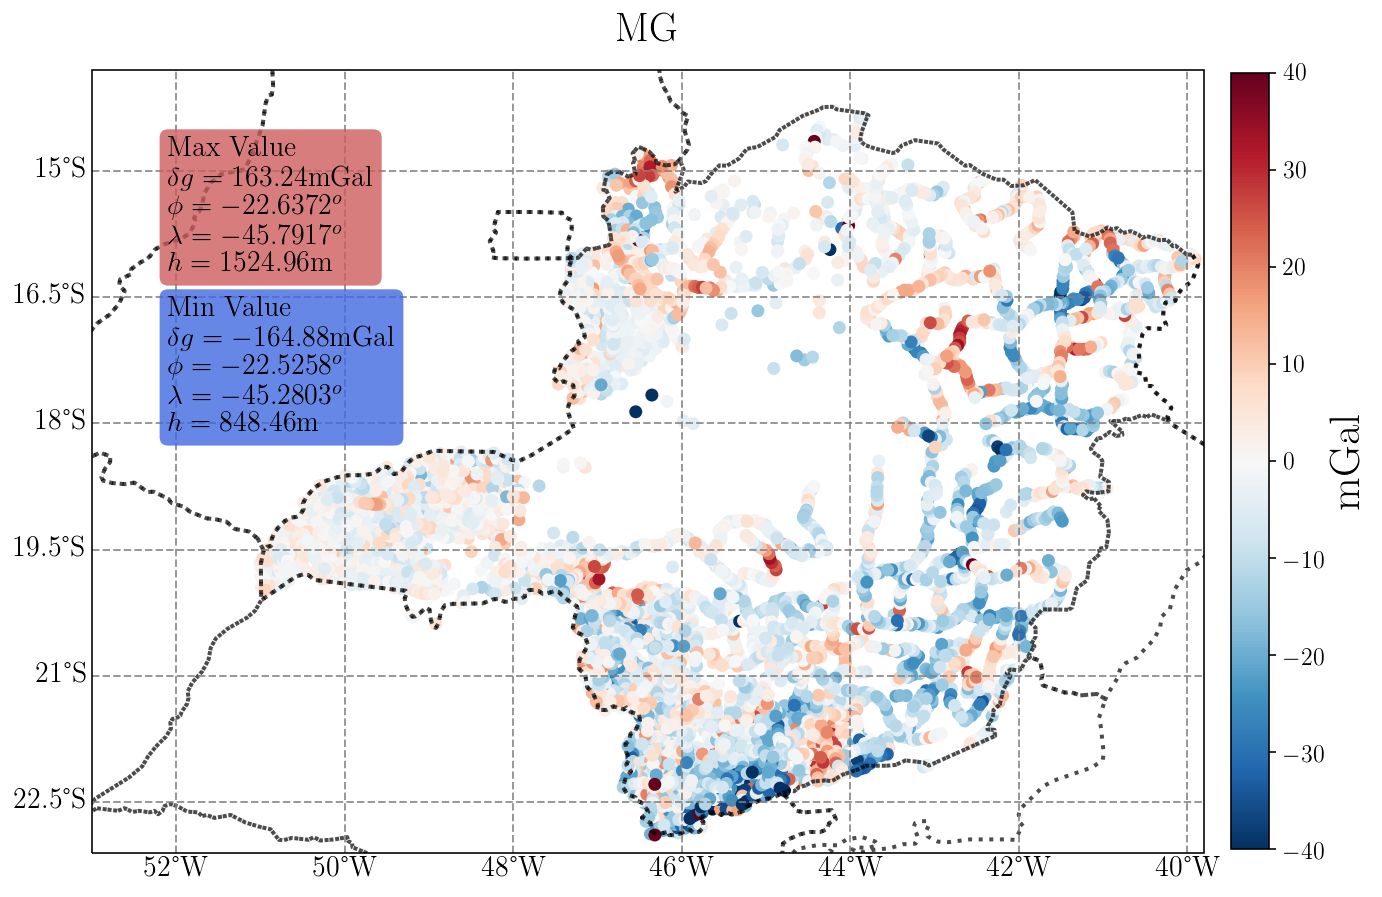

In [35]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-53.,-39.8,-23.1,-13.8], \
         sign=(-52.1,-52.1,-16.2,-18.1), lim_val=(True, 40.))

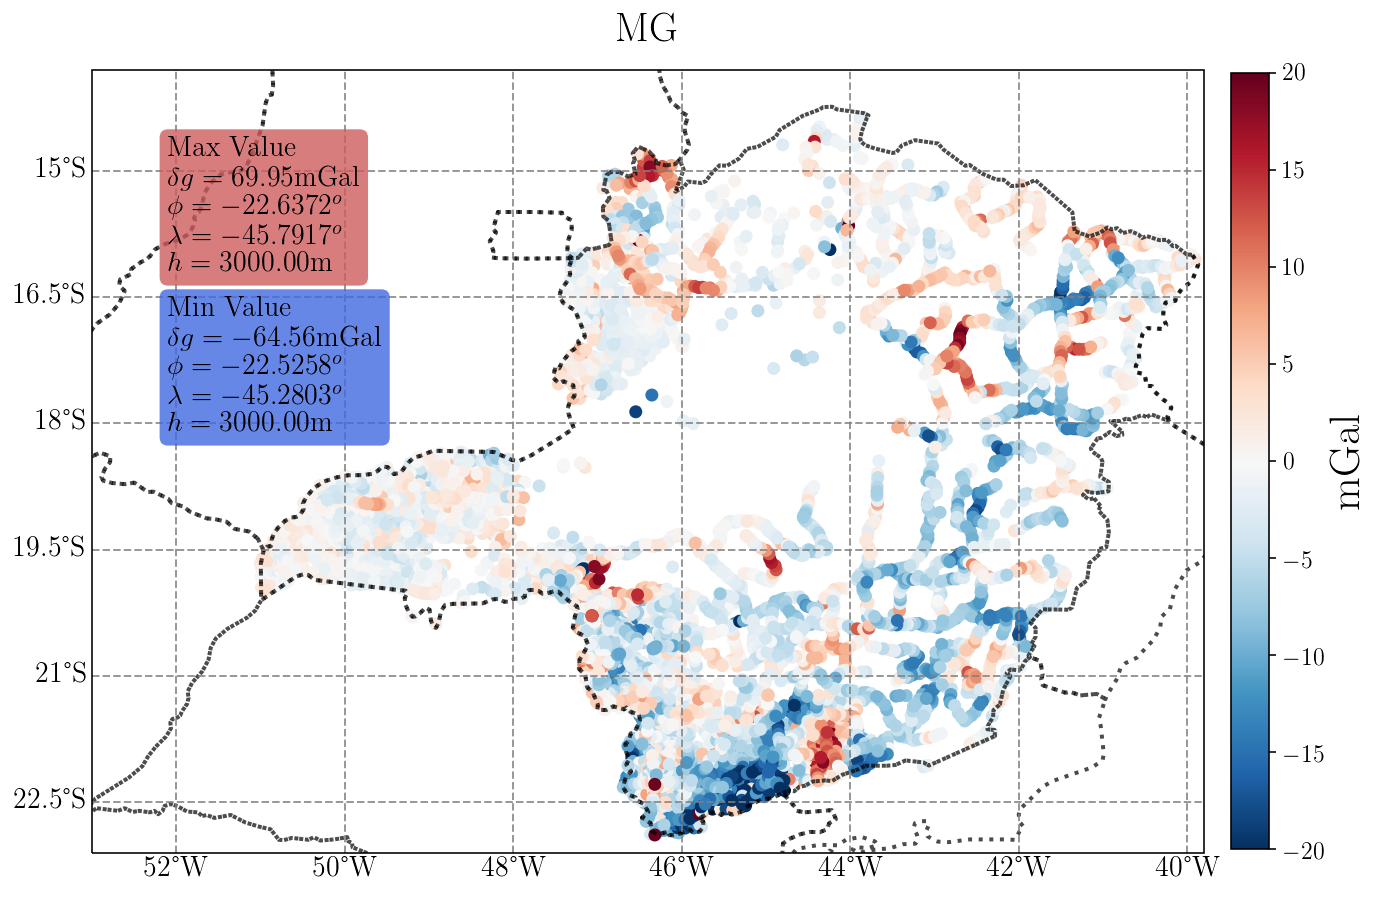

In [36]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(12.,14.), \
          region=[-53.,-39.8,-23.1,-13.8], sign=(-52.1,-52.1,-16.2,-18.1), lim_val=(True, 20.))

In [37]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


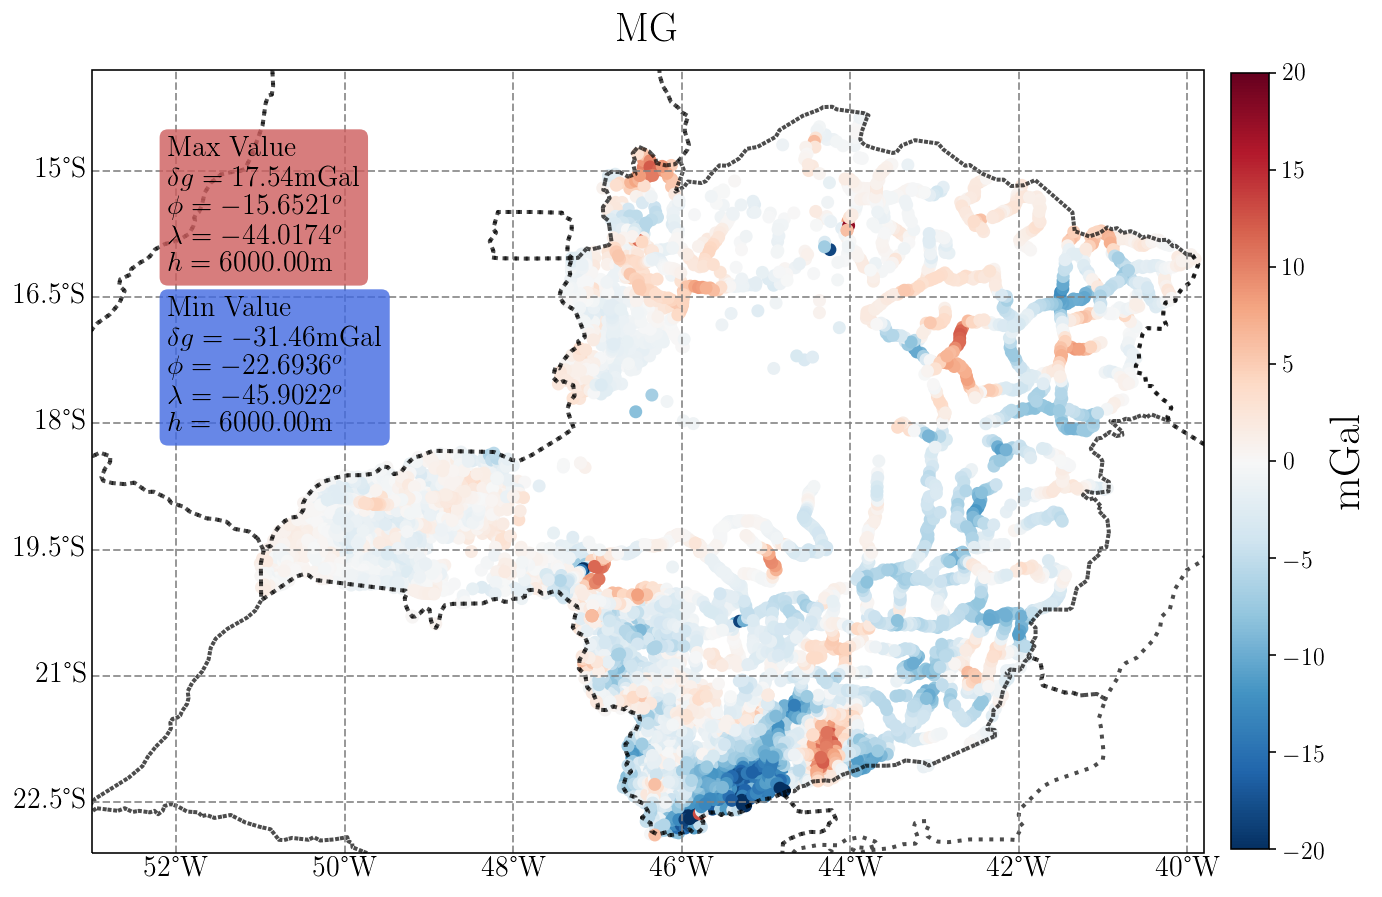

In [38]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(12.,14.), \
          region=[-53.,-39.8,-23.1,-13.8], sign=(-52.1,-52.1,-16.2,-18.1), lim_val=(True, 20.))

In [39]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


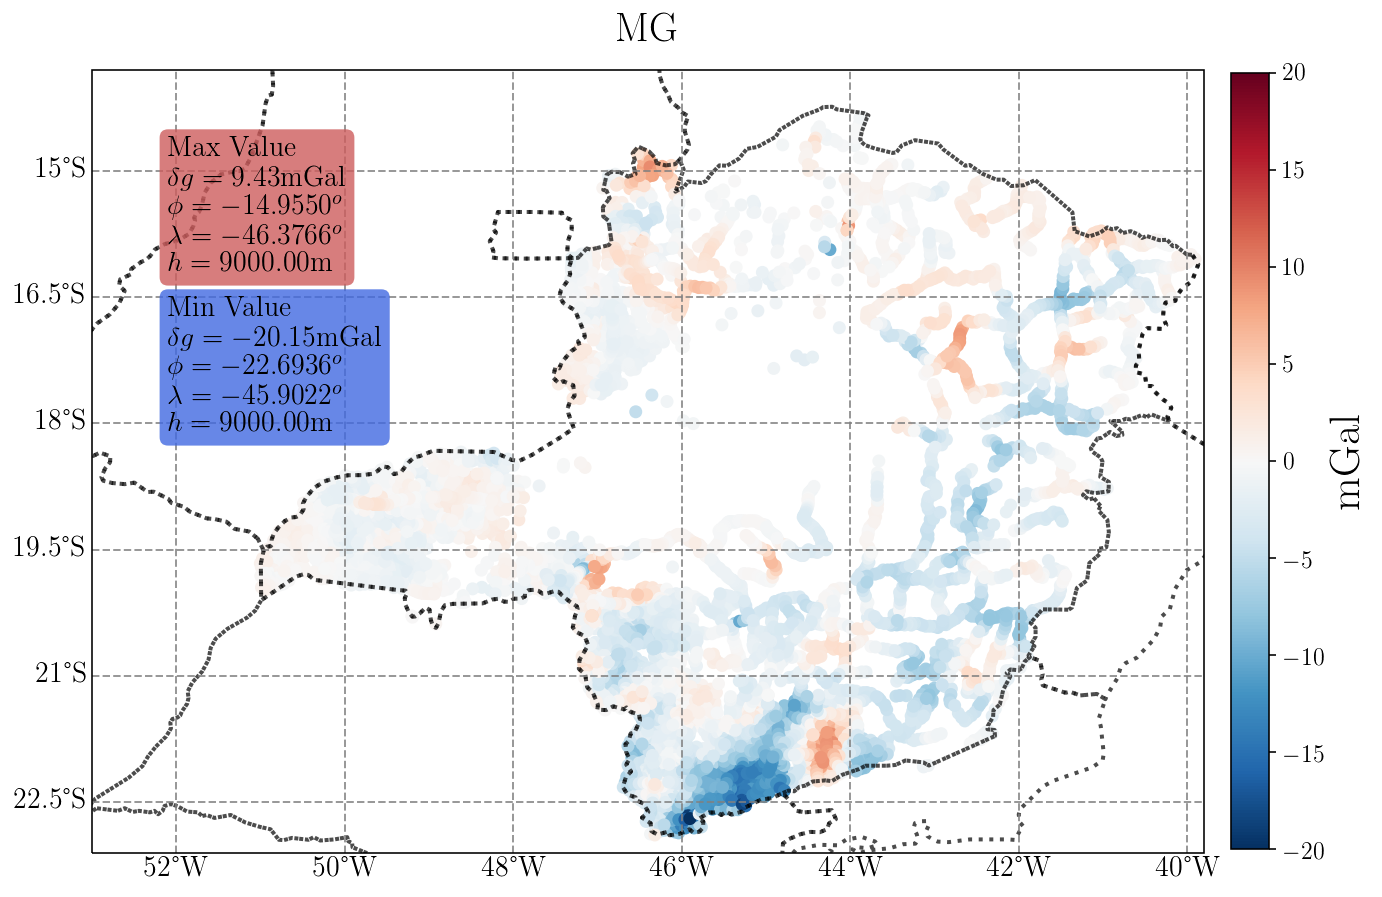

In [40]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(12.,14.), \
          region=[-53.,-39.8,-23.1,-13.8], sign=(-52.1,-52.1,-16.2,-18.1), lim_val=(True, 20.))